In [20]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [80]:
train_df = pd.read_csv(r'dataset/emotiv/train_real_data_a_b_c.csv')
train_df = train_df.drop(columns=['User'])

In [81]:
X = train_df.iloc[:, 1:].values
y = train_df['Class'].values

In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [83]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [84]:
class X_Brain_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(X_Brain_VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [85]:
input_dim = X_tensor.shape[1]
hidden_dim = 64
latent_dim = 32

In [86]:
vae = X_Brain_VAE(input_dim, hidden_dim, latent_dim)

In [87]:
def vae_loss_mse(recon_x, x, mu, logvar, weight_kl = 0.01):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    logvar = torch.clamp(logvar, min=-10, max=10)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    KLD = KLD * weight_kl
    return MSE + KLD, MSE, KLD
   

In [88]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 100
batch_size = 128

In [89]:
for epoch in range(num_epochs):
    vae.train()
    epoch_loss = 0
    mse_loss =0
    kl_loss =0
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i + batch_size]
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss, mse, kl = vae_loss_mse(recon_batch, batch, mu, logvar)
        loss.backward()
        epoch_loss += loss.item() * batch.size(0)
        mse_loss += mse.item()* batch.size(0)
        kl_loss += kl.item()* batch.size(0)
        optimizer.step()
    average_loss = epoch_loss / len(X_tensor)
    avg_mse = mse_loss / len(X_tensor)
    avg_kl = kl_loss / len(X_tensor)
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, MSE: {avg_mse}, KL: {avg_kl}')

Epoch 1, Loss: 0.9273, MSE: 0.8993371694176285, KL: 0.02791887053323013
Epoch 2, Loss: 0.8020, MSE: 0.759444221743831, KL: 0.04252078257225178
Epoch 3, Loss: 0.7619, MSE: 0.7158686028586494, KL: 0.04605786127072793
Epoch 4, Loss: 0.7376, MSE: 0.6988159987661574, KL: 0.038800557647590286
Epoch 5, Loss: 0.7307, MSE: 0.6931310750820019, KL: 0.037559105373091164
Epoch 6, Loss: 0.7254, MSE: 0.68921009655352, KL: 0.03622612572378582
Epoch 7, Loss: 0.7229, MSE: 0.6864748786996913, KL: 0.03644244433553131
Epoch 8, Loss: 0.7202, MSE: 0.6842365626935606, KL: 0.035963740806888654
Epoch 9, Loss: 0.7165, MSE: 0.6821006041985971, KL: 0.03444342555271255
Epoch 10, Loss: 0.7153, MSE: 0.6805527603184736, KL: 0.034713948600822025
Epoch 11, Loss: 0.7148, MSE: 0.6803086629620305, KL: 0.03450199867840167
Epoch 12, Loss: 0.7135, MSE: 0.6788569560757389, KL: 0.03468743811051051
Epoch 13, Loss: 0.7120, MSE: 0.6781311812224211, KL: 0.033910125024892664
Epoch 14, Loss: 0.7117, MSE: 0.6773530933592055, KL: 0.034

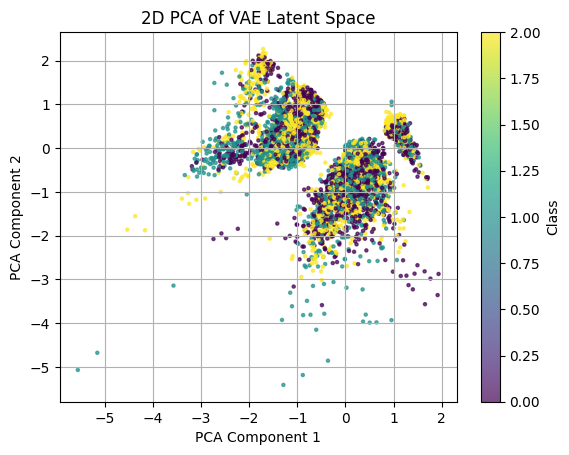

In [92]:
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(X_tensor)

mu_np = mu.numpy()


pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu_np)

plt.figure()
plt.scatter(mu_pca[:, 0], mu_pca[:, 1],c=y, s=5, alpha=0.7)
plt.colorbar(label='Class')
plt.title('2D PCA of VAE Latent Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [99]:
vae.eval()
new_samples = []
new_labels = []

with torch.no_grad():
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i + batch_size]
        labels = y_tensor[i:i + batch_size]

        # Encode the batch to get the latent space representation
        recon_batch, mu, logvar = vae(batch)
        z = vae.reparameterize(mu, logvar)

        # Decode the latent representation to generate new samples
        generated_samples = vae.decode(z)

        # Store the generated samples and their corresponding labels
        if len(generated_samples.numpy()) == len(labels.numpy()):
            new_samples.append(generated_samples.numpy())
            new_labels.append(labels.numpy())

In [102]:
new_samples = np.vstack(new_samples)
new_labels = np.hstack(new_labels)

In [103]:
new_samples_original_scale = scaler.inverse_transform(new_samples)

In [104]:
columns_original = ['AF3 delta std',
 'AF3 delta m',
 'AF3 theta std',
 'AF3 theta m',
 'AF3 alpha std',
 'AF3 alpha m',
 'AF3 beta std',
 'AF3 beta m',
 'F7 delta std',
 'F7 delta m',
 'F7 theta std',
 'F7 theta m',
 'F7 alpha std',
 'F7 alpha m',
 'F7 beta std',
 'F7 beta m',
 'F3 delta std',
 'F3 delta m',
 'F3 theta std',
 'F3 theta m',
 'F3 alpha std',
 'F3 alpha m',
 'F3 beta std',
 'F3 beta m',
 'FC5 delta std',
 'FC5 delta m',
 'FC5 theta std',
 'FC5 theta m',
 'FC5 alpha std',
 'FC5 alpha m',
 'FC5 beta std',
 'FC5 beta m',
 'T7 delta std',
 'T7 delta m',
 'T7 theta std',
 'T7 theta m',
 'T7 alpha std',
 'T7 alpha m',
 'T7 beta std',
 'T7 beta m',
 'P7 delta std',
 'P7 delta m',
 'P7 theta std',
 'P7 theta m',
 'P7 alpha std',
 'P7 alpha m',
 'P7 beta std',
 'P7 beta m',
 'O1 delta std',
 'O1 delta m',
 'O1 theta std',
 'O1 theta m',
 'O1 alpha std',
 'O1 alpha m',
 'O1 beta std',
 'O1 beta m',
 'O2 delta std',
 'O2 delta m',
 'O2 theta std',
 'O2 theta m',
 'O2 alpha std',
 'O2 alpha m',
 'O2 beta std',
 'O2 beta m',
 'P8 delta std',
 'P8 delta m',
 'P8 theta std',
 'P8 theta m',
 'P8 alpha std',
 'P8 alpha m',
 'P8 beta std',
 'P8 beta m',
 'T8 delta std',
 'T8 delta m',
 'T8 theta std',
 'T8 theta m',
 'T8 alpha std',
 'T8 alpha m',
 'T8 beta std',
 'T8 beta m',
 'FC6 delta std',
 'FC6 delta m',
 'FC6 theta std',
 'FC6 theta m',
 'FC6 alpha std',
 'FC6 alpha m',
 'FC6 beta std',
 'FC6 beta m',
 'F4 delta std',
 'F4 delta m',
 'F4 theta std',
 'F4 theta m',
 'F4 alpha std',
 'F4 alpha m',
 'F4 beta std',
 'F4 beta m',
 'F8 delta std',
 'F8 delta_m',
 'F8 theta std',
 'F8 theta m',
 'F8 alpha std',
 'F8 alpha m',
 'F8 beta std',
 'F8 beta m',
 'AF4 delta std',
 'AF4 delta m',
 'AF4 theta std',
 'AF4 theta m',
 'AF4 alpha std',
 'AF4 alpha m',
 'AF4 beta std',
 'AF4 beta m']

In [105]:
generated_df = pd.DataFrame(new_samples_original_scale)

In [107]:
generated_df.columns = columns_original

In [108]:
generated_df['Class'] = new_labels
generated_df['User']  = -1 #We are labeling synthetic data with -1.

In [109]:
generated_df

,AF3 delta std,AF3 delta m,AF3 theta std,AF3 theta m,AF3 alpha std,AF3 alpha m,AF3 beta std,AF3 beta m,F7 delta std,F7 delta m,...,AF4 delta std,AF4 delta m,AF4 theta std,AF4 theta m,AF4 alpha std,AF4 alpha m,AF4 beta std,AF4 beta m,Class,User
0,3572.251465,2065.047607,1.027491,2.499178,0.972211,2.317545,2.518588,3.346656,3570.063965,2063.318604,...,3608.941650,2110.946533,7.112807,18.295897,7.514963,18.117973,31.861725,33.815777,0.0,-1
1,3572.243164,2065.031006,1.027216,2.413344,0.895480,2.175995,2.518588,3.346656,3570.063965,2063.318604,...,3582.292236,2081.824463,3.021349,7.682709,3.046305,7.748960,13.268205,14.789607,0.0,-1
2,3572.243164,2065.031006,1.027216,2.413344,0.895480,2.175995,2.518588,3.346656,3570.063965,2063.318604,...,3582.292236,2081.824463,3.021349,7.682709,3.046305,7.748960,13.268205,14.789607,1.0,-1
3,3575.652100,2067.297119,1.029871,2.467053,0.910568,2.229594,3.266980,4.086492,3574.072510,2065.801025,...,3582.570801,2082.207275,3.021349,7.682711,3.046305,7.748960,13.268218,14.789607,0.0,-1
4,3574.435791,2065.115967,1.027216,2.413344,0.895612,2.178377,2.518588,3.346656,3570.063965,2063.318604,...,3603.880371,2092.850098,3.027988,7.799204,3.047586,7.790217,31.894800,17.924402,2.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,3572.267578,2065.056885,1.030663,2.499085,0.941259,2.313831,3.299365,4.111955,3574.071533,2065.800537,...,3582.293457,2081.912842,3.021900,7.688936,3.046854,7.751684,13.268853,14.789776,2.0,-1
8636,3572.246094,2065.033203,1.032365,2.436346,0.925978,2.239569,3.305073,4.118255,3574.072510,2065.801025,...,3582.292236,2081.825439,3.021349,7.682709,3.046305,7.748960,13.268205,14.789607,1.0,-1
8637,3572.243164,2065.031006,1.027216,2.413344,0.895480,2.175995,2.518588,3.346656,3570.063965,2063.318604,...,3582.292236,2081.824463,3.021349,7.682709,3.046305,7.748960,13.268205,14.789607,0.0,-1
8638,3573.993896,2065.051758,1.027216,2.413344,0.895483,2.176215,2.518588,3.346656,3570.063965,2063.318604,...,3603.879883,2087.653320,3.021496,7.687674,3.046354,7.750203,31.917408,15.599189,0.0,-1


In [111]:
generated_df.to_csv(r'dataset/emotiv/Dataset/synthetic/generated_synthetic_df.csv', index=False)

In [112]:
#Concat real dataset with synthetic


In [113]:
real_synthetic_df = pd.concat([generated_df, train_df], axis=0)

In [119]:
real_synthetic_df.to_csv(r'dataset/emotiv/Dataset/synthetic/real_and_generated_synthetic_df.csv', index=False)

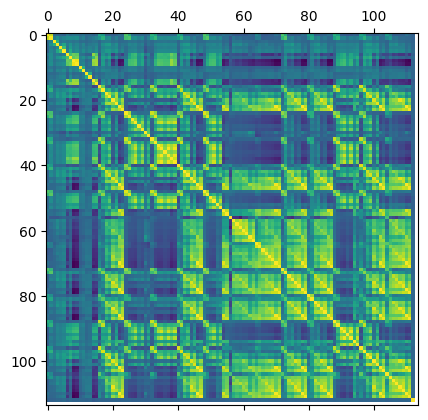

In [120]:
plt.matshow(real_synthetic_df.corr())
plt.show()

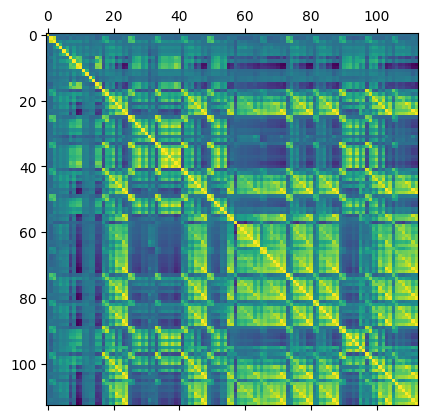

In [121]:
plt.matshow(train_df.corr())
plt.show()